In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol, expand
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

Using TensorFlow backend.


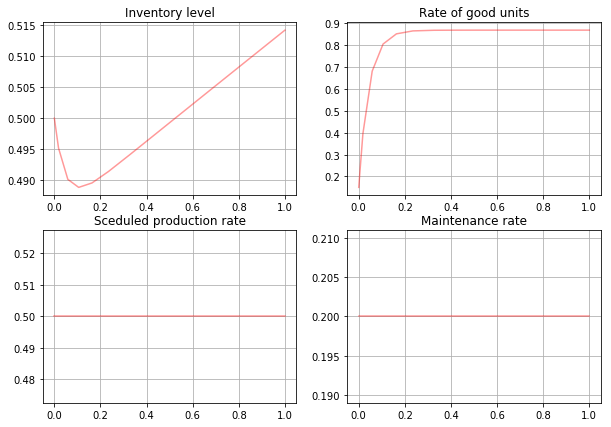

In [2]:
S    = 0.40
a    = 3
teth = 0.01

def lv_system(t, state):
    I = state[0]
    p = state[1]
    u = state[2]
    m = state[3]
    
    # I^ = I/100
    # u^ = u/100
    # m^ = m/100
    return np.array([ p*u - teth*I - S,
                     -a*p - 100*m*p + 100*m,
                      0,
                      0])



t = 1
state0 = np.array([0.50, 0.15, 0.50, 0.2])

X = solve_ivp(lv_system, [0, t], state0, max_step=0.1)
X_rk = X
plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.title('Inventory level')
plt.plot(X.t, X.y[0, :], 'r-', alpha = 0.4)
plt.grid()
plt.subplot(222)
plt.title('Rate of good units')
plt.plot(X.t, X.y[1, :], 'r-', alpha = 0.4)
plt.grid()
plt.subplot(223)
plt.title('Sceduled production rate')
plt.plot(X.t, X.y[2, :], 'r-', alpha = 0.4)
plt.grid()
plt.subplot(224)
plt.title('Maintenance rate')
plt.plot(X.t, X.y[3, :], 'r-', alpha = 0.4)
plt.grid()

plt.show()


In [3]:
I = Symbol('I')
p = Symbol('p')
u = Symbol('u')
m = Symbol('m')

state = np.array([I, p, u, m])

right_hand_side = [p*u - teth*I - S,
                  -a*p - 100*m*p + 100*m,
                   0*u,
                   0*m]

order = 3
map_builder = LieMapBuilder(state, right_hand_side, order=order)

[I p u m]
[-0.01*I + p*u - 0.4, -100*m*p + 100*m - 3*p, 0, 0]


In [4]:
R = [
np.array([[0],
          [0],
          [0],
          [0]
         ]),
np.array([[0.999900004999833, 0, 0, 0],
          [0, 0.970445533548511, 0, 0.985148881716285],
          [0, 0, 1, 0],
          [0, 0, 0, 1]
         ]),
np.array([[0, 0, 0, 0, 0, 0.00985099379642872, 0, 0, 0.00495020734125086, 0],
          [0, 0, 0, 0, 0, 0, -0.970445533547966, 0, 0, -0.490111605610645],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
         ]),
np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0049009518712063, 0, 0, 0, -0.0016418490014853, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.485222766810102, 0, 0, 0, 0.162961293351448],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
         ]),
]

In [5]:
W = map_builder.convert_weights_to_full_nn(R)

dim = len(state)

map = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
model = Sequential()
model.add(map)
map.set_weights(W)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:622: UserWarning: Class `core.Lie.LieLayer` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


In [6]:
import itertools

def error(I, p, I0, p0, u1, u2, u3, m1, m2, m3):
    #E1 = 0.999900004999833*I+0.00140728482806125*p*u1+0.00281456965612249*p*u2+0.00562913931224499*p*u3+4.93156368629932E-05*m1*u1+9.62379078346085E-05*m2*u1+0.000182902352103705*m3*u1+9.86312737259865E-05*m1*u2+0.000192475815669217*m2*u2+0.00036580470420741*m3*u2+0.000197262547451973*m1*u3+0.000384951631338434*m2*u3+0.00073160940841482*m3*u3-5.00097129714929E-05*m1*p*u1-0.000100019425942986*m2*p*u1-0.000200038851885971*m3*p*u1-0.000100019425942986*m1*p*u2-0.000200038851885971*m2*p*u2-0.000400077703771943*m3*p*u2-0.000200038851885971*m1*p*u3-0.000400077703771943*m2*p*u3-0.000800155407543886*m3*p*u3-4.78673178275598E-06*m1*m2*u1-9.57346356551196E-06*m1*m3*u1-1.91469271310239E-05*m2*m3*u1-9.57346356551196E-06*m1*m2*u2-1.91469271310239E-05*m1*m3*u2-3.82938542620478E-05*m2*m3*u2-1.91469271310239E-05*m1*m2*u3-3.82938542620478E-05*m1*m3*u3-7.65877085240956E-05*m2*m3*u3-1*I0
    #E2 = 0.970445533548511*p+0.0679265960755081*m1+0.131208382676895*m2+0.245262844891864*m3-0.0668419117492929*m1*p-0.128732570776034*m2*p-0.237660130661859*m3*p-0.00893328958960279*m1*m2-0.0164412617446448*m1*m3-0.0314572060547289*m2*m3+0.00990250544510411*m1*m2*p+0.0198050108902082*m1*m3*p+0.0396100217804164*m2*m3*p+0.00285063486912153*m1*m2*m3-1*p0
    
    E1 = 0.999900004999833*I+0.000844370896836748*p*u1+0.0016887417936735*p*u2+0.00337748358734699*p*u3+2.9589382117796E-05*m1*u1+5.77427447007651E-05*m2*u1+0.000109741411262223*m3*u1+5.91787642355919E-05*m1*u2+0.00011548548940153*m2*u2+0.000219482822524446*m3*u2+0.000118357528471184*m1*u3+0.00023097097880306*m2*u3+0.000438965645048892*m3*u3-3.00058277828957E-05*m1*p*u1-6.00116555657914E-05*m2*p*u1-0.000120023311131583*m3*p*u1-6.00116555657914E-05*m1*p*u2-0.000120023311131583*m2*p*u2-0.000240046622263166*m3*p*u2-0.000120023311131583*m1*p*u3-0.000240046622263166*m2*p*u3-0.000480093244526331*m3*p*u3-2.87203906965359E-06*m1*m2*u1-5.74407813930717E-06*m1*m3*u1-1.14881562786143E-05*m2*m3*u1-5.74407813930717E-06*m1*m2*u2-1.14881562786143E-05*m1*m3*u2-2.29763125572287E-05*m2*m3*u2-1.14881562786143E-05*m1*m2*u3-2.29763125572287E-05*m1*m3*u3-4.59526251144574E-05*m2*m3*u3-1*I0
    E2 = 0.970445533548511*p+0.0679265960755081*m1+0.131208382676895*m2+0.245262844891864*m3-0.0668419117492929*m1*p-0.128732570776034*m2*p-0.237660130661859*m3*p-0.00893328958960279*m1*m2-0.0164412617446448*m1*m3-0.0314572060547289*m2*m3+0.00990250544510411*m1*m2*p+0.0198050108902082*m1*m3*p+0.0396100217804164*m2*m3*p+0.00285063486912153*m1*m2*m3-1*p0

    
    return E1*E1 + E2*E2

def getMin(I, p, I0, p0):
    #return 0.5, 0.2
    min_e = float("inf")
    res = [0,0,0,0,0,0]
    for seq in itertools.product("01", repeat=6):
        bin_vars = [int(i) for i in seq]
        cur_er = error(I, p, I0, p0, bin_vars[0], bin_vars[1], bin_vars[2], bin_vars[3], bin_vars[4], bin_vars[5])
        if cur_er < min_e:
            min_e = cur_er
            res = bin_vars
            
    u1, u2, u3, m1, m2, m3 = res[0], res[1], res[2], res[3], res[4], res[5]
    return 0.6*(u1 * 1.0 / 7 + u2 * 2.0 / 7 + u3 * 4.0 / 7), 0.5*(m1 * 1.0 / 7 + m2 * 2.0 / 7 + m3 * 4.0 / 7)

In [12]:
def predict(model, X0, u, m, N=10):
    X = X0.ravel()
    X[2] = u
    X[3] = m
    for i in xrange(N):
        X = model.predict(X.reshape((-1,4)))
    return X

def predictOptimum(model, X0, I0, p0, N=10):
    X = X0.ravel()
    I = X[0]
    p = X[1]
    
    X[2], X[3] = getMin(I, p, I0, p0)
    return model.predict(X.reshape((-1, 4)))
#     u, m = getMin(I, p, I0, p0)
#     return predict(model, X0, u, m, N)
    

[[40.45  0.15  0.5   0.2 ]]
start simulation
elapsed time: 0.566992998123 sec


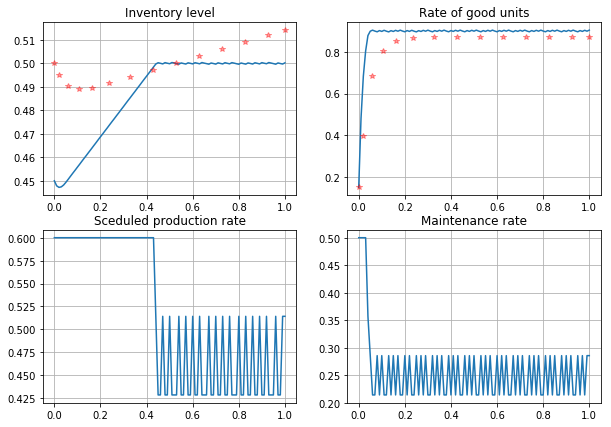

In [13]:
state0 = np.array([0.45+S/teth, 0.15, 0.50, 0.2])

X = []
X.append(state0.reshape((-1,4)))
print(X[0])
import time
print('start simulation')
start = time.time()
epoch_n = 100
h = 0.01
L = 1+h

u = [0.7, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
m = [0.2, 0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
for i in xrange(epoch_n):
    #xtmp = model.predict(X[-1])
    #xtmp = predict(model, X[-1], u[i], m[i])
    xtmp = predictOptimum(model, X[-1], 0.5+S/teth, 0.9)
    X.append(xtmp) 
print('elapsed time: %s sec'% (time.time()-start))

X = np.array(X)

plt.figure(figsize=(10, 7))
plt.subplot(221)
plt.title('Inventory level')
plt.plot(np.arange(0, L, h), X[:,:,0]-S/teth, '-', markersize=3)
plt.plot(X_rk.t, X_rk.y[0, :], 'r*', alpha = 0.4)
plt.grid()
plt.subplot(222)
plt.title('Rate of good units')
plt.plot(np.arange(0, L, h), X[:,:,1], '-', markersize=3)
plt.plot(X_rk.t, X_rk.y[1, :], 'r*', alpha = 0.4)
plt.grid()
plt.subplot(223)
plt.title('Sceduled production rate')
plt.plot(np.arange(0, L, h), X[:,:,2], '-', markersize=3)
plt.grid()
plt.subplot(224)
plt.title('Maintenance rate')
xx = X[:,:,3].ravel()
plt.plot(np.arange(0, L, h), np.round(xx, 8), '-', markersize=3)
# print(xx)
plt.grid()
plt.show()